# Machine Learning for Genomics - Assignment 1 
**Carlos Angel (jcc2340)** 

10/06/2023

In [1]:
import torch
#assert(torch.cuda.is_available())
device = "cpu"
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import pandas as pd
from pathlib import Path
sns.set() # nice default plot formatting


/gpfs/commons/home/cangel/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

First let's load the gene expression data. We'll use pandas to read the data in and take a look at it. Note you may need to adjust the file path below (the Files tab on the left hand edge of the Colab notebook should help, the Assignment directory might end up in Shared drives). Alternatively you can try go to the Assignment 1 gdrive directory, click on "Assignment 1" and then do "Add shortcut to drive" to have it show up in "My Drive".

In [2]:

path_to_assigment_dir = Path("/gpfs/commons/home/cangel/lulab/courses/MachineLearningForGenomics/HW/HW1/files")
express_all = pd.read_csv(path_to_assigment_dir / "Cell_line_RMA_proc_basalExp.txt.zip", sep = "\t")
express_all.iloc[:6,:8]

,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533
1,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],2.964585,2.777716,2.643508,2.817923,2.957739,2.889677
2,DPM1,dolichyl-phosphate mannosyltransferase polypep...,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987
3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903
4,C1orf112,chromosome 1 open reading frame 112 [Source:HG...,3.380681,3.732485,3.236620,3.558414,3.840373,3.815055
5,FGR,Gardner-Rasheed feline sarcoma viral (v-fgr) o...,3.324692,3.152404,3.241246,3.101247,3.001802,3.298915


The two columns are the gene symbol and gene name. The remaining columns are the expression values for each cell line. The column name is "DATA." followed by the "COSMIC ID", a unique identifier for each cell line.

Next we'll load the drug screen data.

In [3]:
ic50_all = pd.read_csv(path_to_assigment_dir / "TableS4A_ic50.txt.gz", sep = "\t", index_col = 0)
ic50_all.iloc[:6,:8]

,cell_line,TL-2-105,TAK-715,CP466722,BMS-345541,Genentech Cpd 10,GSK429286A,Ruxolitinib
cosmic_id,,,,,,,,
910944,ALL-PO,1.41,2.11,-0.76,1.39,-1.40,3.68,3.08
1295741,AMO-1,3.36,3.05,1.72,2.19,1.54,3.54,2.99
910692,COLO-668,3.40,3.10,3.07,1.23,0.31,3.57,3.73
1297439,COR-L95,3.31,6.10,2.95,2.85,3.74,5.22,3.72
906838,DG-75,3.65,3.11,2.18,1.59,2.44,5.30,4.15
753555,EC-GI-10,5.00,4.00,5.45,3.37,5.00,5.67,4.33


The index is set to be the cosmic_id. The first column is the cell line name. The remaining columns are "IC50"s for each cell line, i.e. the concentration of drug required to inhibit growth by 50%.

# Data mungin
We need to do a little data munging: get the common cell lines between the two DataFrame and get the ordering the same.

In [4]:
common_cell_lines = ["DATA.%i" % g for g in ic50_all.index] #adding as in for loop
common_cell_lines = list(set(common_cell_lines).intersection( express_all.columns.tolist() ))
common_cell_lines = sorted(common_cell_lines) # required for reproducibility, set order is undefined #list of DATA.i
expression = express_all[common_cell_lines] #all expressed in cells, retrieving genes for common cell lines 
expression.shape #df with all values in cell lines

(17737, 962)

In [5]:
#expression
express_all
#common cell line is just the cosmic id retrieved from ic50_all.index that includes the ic50 for each cell line
#express all are the genes that are expressed in each cell line
    #The two columns are the gene symbol and gene name. The remaining columns are the expression values for each cell line. The column name is "DATA." followed by the "COSMIC ID", a unique identifier for each cell line.


,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,DATA.1240135,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],2.964585,2.777716,2.643508,2.817923,2.957739,2.889677,2.828203,2.874751,...,2.798847,2.745137,2.976406,2.852552,2.622630,2.639276,2.879890,2.521169,2.870468,2.834285
2,DPM1,dolichyl-phosphate mannosyltransferase polypep...,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987,10.264385,10.205931,...,10.486486,10.442951,10.311962,10.454830,10.418475,11.463742,10.557777,10.792750,9.873902,10.788218
3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,3.715033,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
4,C1orf112,chromosome 1 open reading frame 112 [Source:HG...,3.380681,3.732485,3.236620,3.558414,3.840373,3.815055,3.011867,3.268449,...,3.726833,3.947744,3.806584,3.196988,3.814831,4.384732,4.247189,3.071359,3.230197,3.435795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17732,NaN,hsa-mir-5195 [Source:miRBase;Acc:MI0018174],2.852537,2.776771,2.685307,3.436412,2.951270,3.233383,3.810246,2.792116,...,2.699663,5.190438,3.253381,3.000088,2.846830,2.959009,2.974475,2.903894,2.857956,3.033662
17733,POLRMTP1,polymerase (RNA) mitochondrial (DNA directed) ...,3.130696,3.260982,3.176239,3.074432,3.213545,3.382112,3.200106,2.829053,...,2.773728,2.988250,3.514337,3.254306,3.139208,3.007502,3.088841,2.847505,2.832840,2.817057
17734,UBL5P2,ubiquitin-like 5 pseudogene 2 [Source:HGNC Sym...,9.986616,9.002814,9.113243,9.958284,9.938978,8.714820,9.396484,9.779745,...,9.593772,9.506062,9.945730,9.890244,10.018968,9.332193,10.742651,8.544696,9.900550,9.071943
17735,TBC1D3P5,"TBC1 domain family, member 3 pseudogene 5 [Sou...",3.073724,3.000182,2.916274,3.256500,3.396126,3.497439,3.193505,3.254539,...,3.407260,3.256900,3.189972,3.155584,3.357660,3.435411,3.317945,3.174515,3.243563,3.324517


In [6]:
cosmic_ids = [int(g[5:]) for g in common_cell_lines] #retrieving ids, same as above but removing DATA. and converting to int
ic50 = ic50_all.loc[cosmic_ids,:] #getting ic50 for specific cosmic IDs/index
ic50.shape


(962, 266)

Keep in mind that 18% of the IC50s are missing

In [7]:
import numpy as np
np.isnan(ic50.iloc[:,1:]).mean().mean()

0.1836661044208214

For now we'll focus on just one drug: PFI-1, an inhibitor of two related genes BRD2 and BRD4. The IC50 values will be our y and gene expression measurements will be our X. We'll do as much as possible in pytorch to utilize Colab's GPU.

We'll filter for non-missing IC50, and normalize both y and columns of X to have 0 mean and variance 1 ("Z-transform").

In [8]:
y_all = ic50["PFI-1"] #IC50 values for just PFI1, cosmic id  - value
is_missing = np.isnan(y_all) # nan values = missing
y_unnorm = torch.tensor(y_all[~is_missing].to_numpy(), dtype = torch.float) #creating tensor for ic50 values, data will be floats
# y_all[~is_missing] is removing the missing values
y = (y_unnorm - y_unnorm.mean()) / y_unnorm.std() # normalize z-score

X_all = expression.to_numpy().transpose() # X should be [N x P], creating matrix of expressed genes
X_unnorm = torch.tensor(X_all[~is_missing,:], dtype = torch.float) #tensor for expression values
#remove missing values now in the expression data
X = (X_unnorm - X_unnorm.mean(0, keepdims=True)) / X_unnorm.std(0, keepdims=True)

# Training, validation & test split
We'll split our data into training (80%), validation (10%, for picking lambda) and test (10%, for assessing final performance). Ideally for this data size we'd use cross-validation but that would be a bit slow to wait for.

In [9]:
N = len(y) #number of ic50 values for each cell line in PFI1
print(N)
np.random.seed(1234) # for reproducibility
rand_perm = np.random.permutation(N) #randomly permuting the ic50 values
train_idx = rand_perm[:int(np.ceil(0.8 * N))] #80% of the data from the permutated ic50 values
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))] #starting right after the 80% mark and going up to the 90% mark. 
test_idx = rand_perm[int(np.ceil(0.9 * N)):]#begins from the 90% mark and goes to the end, thus taking the final 10% of the data. 

X_train = X[train_idx,:] #getting expression values for the train, val, and test sets
X_val = X[val_idx,:]
X_test = X[test_idx,:]

y_train = y[train_idx] #getting ic50 values for the train, val, and test sets
y_val = y[val_idx]
y_test = y[test_idx]

rand_perm[:10]

916


array([746, 401,  60, 590,  40, 495, 410, 569, 282, 326])

## Ridge regression

We'll first use the analytic solution to ridge regression, which involves solving a big system of linear equations:

Increasing $\lambda$ gives a smaller slope when performing ridge 


$ \hat{\beta} = (X^T X + N \lambda I)^{-1} X^T y $

Note here we scale $\lambda$ by $N$ (the number of samples, `X.shape[0]`) to make the choice of $\lambda$ less dependent on the sample size. We could equivalently have divided the squared error term in the loss by $N$ (indeed that's what we'll do for gradient descent below).

Your first **task** is to implement this equation in `pytorch`. [2 points]

Useful things to know:
*   `@` is used by both `numpy` and `pytorch` to denote matrix multiplication.
*   In `pytorch` you need to do `X.transpose(0,1)` for the regular matrix transpose, since it support switching other dimensions.
* The identity matrix $I$ can be made with `torch.eye`: you'll get to get the right dimension (from `X.shape`) and pass the appropriate `device`, which you can get from `X.device` (or just hardcode it if you want).
* Check the docs for `torch.linalg.solve` using `?torch.linalg.solve` which is letting us calculate `beta` entirely on the GPU:

Note that both inputs to torch.solve need to be 2D: you can make y a N x 1 matrix with y[:,None]. Also, torch.solve returns both the solution  𝐴−1𝑖𝑛𝑝𝑢𝑡  and the LU decomposition it used to do the solve - we don't need the latter so we ignore it by putting it into the dummy variable denoted by an underscore _.

In [10]:
def ridge_regression(X, y, lamb):
    # TODO! YOUR CODE HERE
    # AX = B
    # X = A^{-1}B
    A_lhs = torch.transpose(X, 0, 1) @ X
    B_rhs = torch.transpose(X, 0, 1) @ y.unsqueeze(-1)
    NL = X.shape[0] * lamb # why do we need to scale by N?
    reg_term = NL * torch.eye(A_lhs.shape[0])
    reg_lhs = A_lhs + reg_term
    beta = torch.linalg.solve(reg_lhs, B_rhs)
    return beta# matrix -> vector

The torch.linalg.solve(B, A) function solves for X in the equation 
AX = B
AX=B. This means you provide A as the coefficient matrix (the matrix you're trying to "invert" or "solve against") and B as the right-hand side matrix/vector, and it will return the solution X.

If you implemented it correctly, the following assertion should pass (it takes a few seconds to do the matrix solve):

In [11]:
beta = ridge_regression(X_train, y_train, lamb = 1.)

In [12]:
assert((beta.std().item() - 0.0018369749886915088) < 1e-6 )

Let's try some different values of the regularization parameter `lambda`.

Text(0, 0.5, 'Validation RMSE')

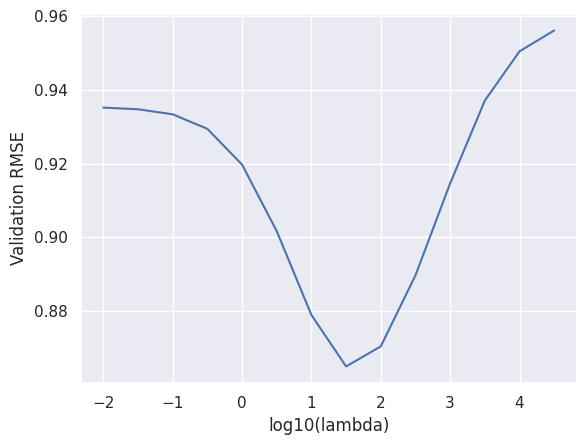

In [13]:
lambdas = 10 ** np.arange(-2, 5, step = 0.5) # try different settings of lambda, but what was lambda again?
#10 to the power of -2 to 5, step size of 0.5
val_rmse = np.zeros_like(lambdas)
# array filled with zeros, and its shape is identical to that of the lambdas array.

for i,lamb in enumerate(lambdas): # try different settings of lambda
    beta = ridge_regression( X_train, y_train, lamb )
    beta = beta[:,0]
    pred_val = X_val @ beta # make predictions on the validation set
    val_rmse[i] = np.sqrt(torch.mean((y_val - pred_val)**2).item()) # item() gets the scalar value

plt.plot(np.log10(lambdas), val_rmse)
plt.xlabel("log10(lambda)")
plt.ylabel("Validation RMSE")

The left hand side here corresponds to overfitting the data, and the right hand side to underfitting, with the optimal `lambda` in between. We can extract the optimal `lambda` as:

In [14]:
optimal_lamb = lambdas[np.argmin(val_rmse)]
optimal_lamb

31.622776601683793

In [15]:
# Temporal to not run the code above
optimal_lamb=31.622776601683793

## Gradient descent for ridge regression

The other way we could fit ridge regression is using gradient descent (GD).

I've implemented the loss function, **you'll need to implement the gradient** for the loss,

Loss function for Ridge Regression


$ \frac1{2N} \sum_{i=1}^N (y_i - X_i \beta)^2 + \frac{\lambda}{2} | \beta |^2_2 $

Considering Mean Squared error, accounting to average the error across all observations.

$ \frac{\lambda}{2} | \beta |^2_2$ 

Is the $Ridge$ regularization term, by preventing values of beta from overfitting. Larger lambdas give more penalty.




THE N HERE IS FOR THE TRAINING DATA, WHICH IS NOT THE THE N FROM THE CODE ABOVE. What is the gradient wrt $\beta$? (we did this in lecture 1 although without the $\frac1N$ factor) [1 point]


We must derivate the MSE and Ridge term with respect to $\beta$

The derivative of $ \frac{1}{2N} \sum_{i=1}^{N} (y_i - x_i^T \beta)^2 $ with respect to $ \beta $:

  $ -\frac{1}{N} X^T (y - X\beta) $

The derivative of $\frac{\lambda}{2}  | \beta |^2_2$  with respect to $\beta$


$ \frac{\lambda}{2} | \beta |^2_2  = \frac{\lambda}{2} \beta^T \beta $

$ \frac{d}{d\beta}(\beta^T \beta ) = 2\beta $ 

$ \frac{\lambda}{2} * 2 \beta $ 


$ \frac{d}{d\beta} ( \frac{\lambda}{2} \beta^T \beta ) = \lambda \beta $

Gradient with respect to $\beta$

  $$ \nabla_\beta L(\beta) = - \frac1{N}  X^T (y - X\beta) + \lambda \beta $$

**TODO YOUR ANSWER HERE**

A correct implementation will result in the assertion passing. Note that it's possible to write the expression you need in terms of `err = y - X @ beta`, which is already calculated and therefore saves some computation. [2 points]

In [16]:
def ridge_regression_gd(X, y, lamb, learning_rate = 0.001, iterations = 300):
    beta = torch.zeros(X.shape[1])
    losses = []
    for k in range(iterations): # in practice we would use an appropriate "stopping criteria"
        err = y - X @ beta
        loss = .5 * (err * err).mean() + .5 * lamb * (beta * beta).sum()
        if np.isnan(loss.item()):
            print("Warning: GD diverged on iteration %i" % k)
            break
        losses.append(loss.item())
        N = X.shape[0]
        grad = -((X.transpose(0,1)) @ err ) / N + lamb * beta
        beta -= learning_rate * grad
    return(beta,losses)



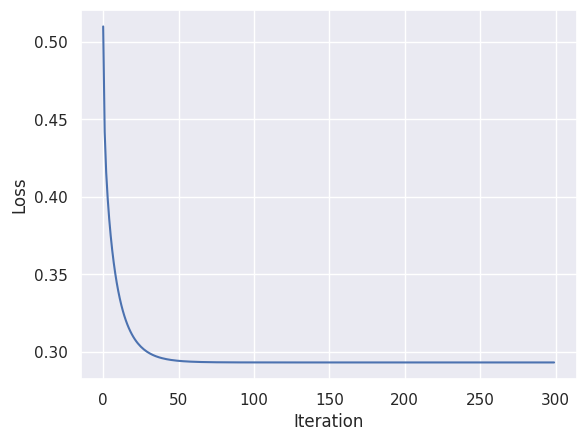

In [17]:
beta,losses = ridge_regression_gd(X_train, y_train, lamb = optimal_lamb)

_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")

assert( np.abs(losses[-1] - 0.2930864095687866 ) < 1e-6 )

loss quantifies how well the current model's predictions match the true data. The goal of gradient descent is to find the model parameters that minimize this loss.

 Try playing around with the learning rate. **Find a value that's too small so that the algorithm doesn't converge in 300 iterations**: [1 point]


Learning rate: 0.001000000000000
Learning rate: 0.000100000000000
Learning rate: 0.000010000000000
Learning rate: 0.000001000000000
Learning rate: 0.000000100000000
Learning rate: 0.000000010000000
Learning rate: 0.000000001000000
Learning rate: 0.000000000100000
Learning rate: 0.000000000010000
Learning rate: 0.000000000001000
Learning rate: 0.000000000000100


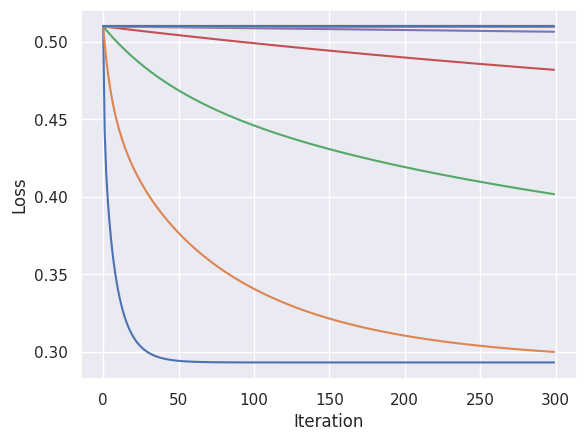

In [18]:
#the algorithm will make very tiny steps towards the minimum. Consequently, it might take an inordinate number of iterations to converge
default_learning_r=0.001
for i in range(0,11):
    print("Learning rate: {:.15f}".format(default_learning_r/10**i))
    _,losses = ridge_regression_gd(X_train, y_train, lamb = optimal_lamb, learning_rate = (default_learning_r/10**i) )

    _ = plt.plot(losses)
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Loss")

Small Learning Rate: a very small learning rate might make the algorithm converge extremely slowly or not at all within a given number of iterations. In this case, the parameter updates are very tiny, and the loss decreases at a slow pace.

Now find a learning rate that's too big so the optimization will diverge and end up giving `nan` values.** [1 point]


Learning rate: 0.001000000000000
Learning rate: 0.002000000000000
Learning rate: 0.004000000000000
Learning rate: 0.008000000000000
Learning rate: 0.016000000000000
Learning rate: 0.032000000000000
Learning rate: 0.064000000000000
Learning rate: 0.128000000000000
Learning rate: 0.256000000000000
Learning rate: 0.512000000000000
Learning rate: 1.024000000000000


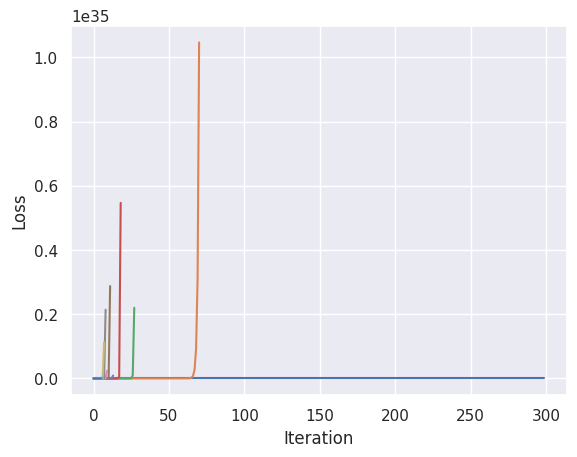

In [19]:
default_learning_r=0.001
for i in range(0,11):
    print("Learning rate: {:.15f}".format(default_learning_r*2**i))
    _,losses = ridge_regression_gd(X_train, y_train, lamb = optimal_lamb, learning_rate = (default_learning_r*2**i) )

    _ = plt.plot(losses)
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Loss")

Large Learning Rate: A very large learning rate can cause the algorithm to overshoot the minimum. Instead of descending towards the minimum, the algorithm can bounce around, possibly getting farther away with each step. 

Note that at at this scale with `P >> N` gradient descent is considerably faster than the matrix solve used above. Let's check we're getting the same answer with both approaches:

In [20]:
beta_analytic = ridge_regression(X_train, y_train, optimal_lamb)
(beta_analytic - beta).abs().mean().item()

0.0006385870510712266

The beta found by the two approaches are almost identical.

Let's take a look at the distribution of the coefficients:  

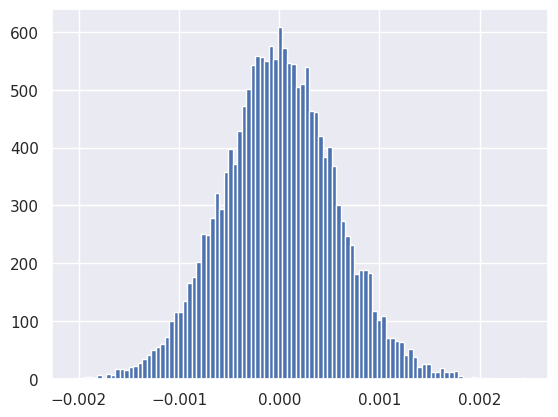

In [21]:
_ = plt.hist(beta_analytic.cpu().numpy(), 100)

These look roughly Gaussian distributed. We can look at the predictions on test data and assess how good these are using the Pearson correlation and hypothesis test (for the correlation being non-zero):  

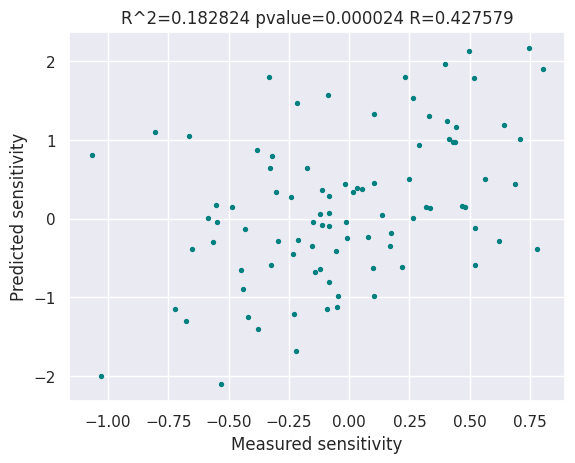

In [22]:
import scipy
pred_test = X_test @ beta_analytic # make predictions on the test set
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())

plt.scatter(pred_test.cpu(), y_test.cpu(),color="teal",s=8)
plt.title("R^2=%f pvalue=%f R=%f" % (R**2, p, R))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

The predicted and observed drug sensitivity measurements are significantly correlated.

R^2 represents the proportion of the variance for the dependent variable that's explained by independent variables in a linear regression model.

## LASSO regression

We can similarly use (sub)gradient descent to fit L1 regularized regression, aka the [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). A subgradient of $|\beta|$ is sign$(\beta)$.

Code the gradient - you hopefully already know how to implement the gradient of the squared error term, so now you just need the regularization term [1 point].



Loss function for Lasso Regression


$ \frac1{2N} \sum_{i=1}^N (y_i - X_i \beta)^2 + {\lambda} | \beta |_1 $

Considering Mean Squared error, accounting to average the error across all observations.

$ {\lambda} | \beta |_1 $ 

Is the $Lasso$ regularization term, by preventing values of beta from overfitting. Larger lambdas give more penalty.

The derivative of $ \frac{1}{2N} \sum_{i=1}^{N} (y_i - x_i^T \beta)^2 $ with respect to $ \beta $:

  $ -\frac{1}{N} X^T (y - X\beta) $

Since the derivative of ${\lambda} | \beta |_1 $  with respect to $\beta$ is not feasible we can use subgradients$

$ {\lambda} * sign\beta$


Gradient of Lasso in respect to $\beta$
$$ \nabla_\beta L(\beta) = - \frac1{N}  X^T (y - X\beta) + {\lambda} * sign\beta $$





In [23]:
def fit_lasso(X, y, lamb, learning_rate = 0.001, iterations = 100):
    beta = torch.zeros(X.shape[1], device=X.device)
    losses = []
    for it in range(iterations):
        err = y - X @ beta
        loss = .5 * (err * err).mean() + lamb * beta.abs().sum()
        if np.isnan(loss.item()):
            print("Warning: GD diverged on iteration %i" % it)
            break
        losses.append(loss.item())
        ### TODO YOUR CODE HERE
        N = X.shape[0]
        MSE = ((X.transpose(0,1)) @ err ) / N 
        lasso_penalty = lamb * torch.sign(beta)
        grad = - MSE + lasso_penalty
        beta -= learning_rate * grad
    return(beta,losses)


In [24]:
beta,_ = fit_lasso(X_train, y_train, learning_rate = 0.001, lamb = 0.01, iterations = 1000)
assert( np.abs(beta.std().item() - 0.0020454663317650557 ) < 1e-6 )

Lambda=0.000001, fitting...
Lambda=0.000010, fitting...
Lambda=0.000100, fitting...
Lambda=0.001000, fitting...
Lambda=0.010000, fitting...
Lambda=0.100000, fitting...


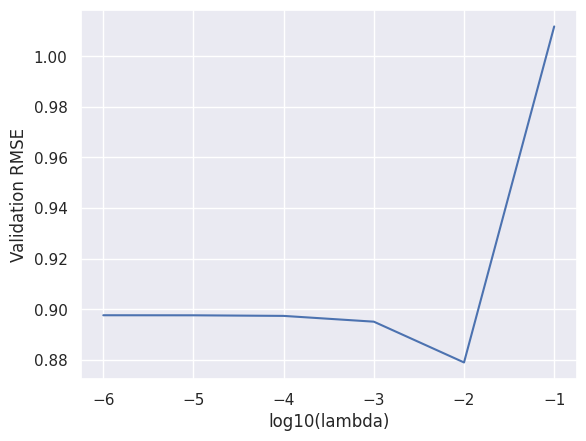

In [25]:
lambdas = 10.**torch.arange(-6,0,step=1,dtype=torch.float)
val_rmse = np.zeros(len(lambdas))
learning_rate = 0.001
for lbd_idx,lamb in enumerate(lambdas):
    print("Lambda=%f, fitting..." % lamb)
    beta, _ = fit_lasso(X_train, y_train, lamb, learning_rate = learning_rate)
    pred_val = X_val @ beta # make predictions on the validation set
    val_rmse[lbd_idx] = np.sqrt(torch.mean((y_val - pred_val)**2).item()) # item() gets the scalar value
_ = plt.plot(np.log10(lambdas.numpy()), val_rmse)
_ = plt.xlabel("log10(lambda)")
_ = plt.ylabel("Validation RMSE")

In [26]:
optimal_lamb = lambdas[np.argmin(val_rmse)]
optimal_lamb.item()

0.009999999776482582

Let's look at the distribution of fitted coefficients for the Lasso:

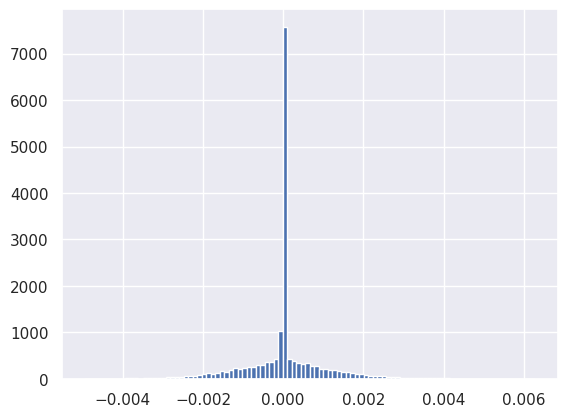

In [27]:
beta_lasso, _ = fit_lasso(X_train, y_train, lamb = optimal_lamb)
beta_lasso_np = beta_lasso.cpu().numpy()
_ = plt.hist(beta_lasso_np, 100)

Note that more coefficients are much more concentrated close to 0 than for the ridge regression.

Next let's look at predictions on the test set again:

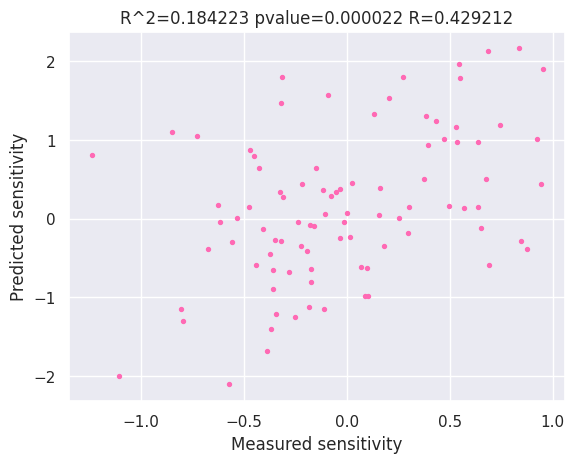

In [28]:
pred_test = X_test @ beta_lasso # make predictions on the test set
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu(),color="hotpink",s=8)
plt.title("R^2=%f pvalue=%f R=%f" % (R**2, p, R))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

The R^2 (proportion of variance explained) is very similar for ridge and lasso regression, but the lasso is potentially more "interpretable" since it has fewer non-zero coefficients.

## Binary classification & Logistic regression

One of the analyses in the GDSC determined sensible thresholds to determine "resistant" vs "sensitive" cell lines for each drug. For PHI-7 the threshold is:

In [29]:
sens_threshold = 1.2307

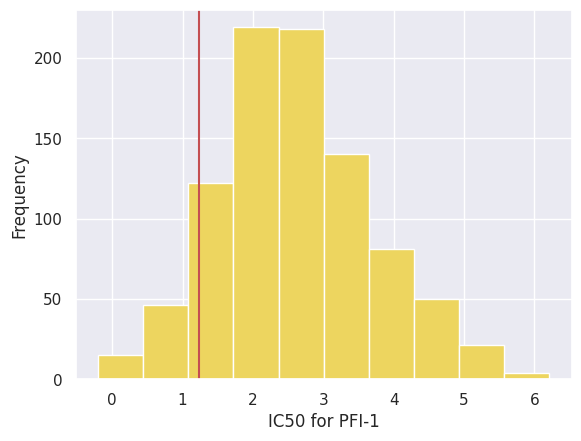

In [30]:
plt.hist(ic50["PFI-1"],color="#edd55f")
plt.xlabel("IC50 for PFI-1")
plt.ylabel("Frequency")
plt.axvline(x=sens_threshold, color='r')

So any cell lines with an IC50 < 1.23 would be considered sensitive, and >1.23 are resistant. Could we predict this binary outcome directly? We'll use logistic regression to do this. Unlike for linear regression we can't just subtract away the mean, so we'll need to include an intercept term. The easy way to do this is to add a column of 1s to X.

In [31]:
X_train_1 = torch.cat((X_train, torch.ones((X_train.shape[0],1))), axis = 1)
X_val_1 = torch.cat((X_val, torch.ones((X_val.shape[0],1))), axis = 1)
X_test_1 = torch.cat((X_test, torch.ones((X_test.shape[0],1))), axis = 1)

In [32]:
y_binary = (y_unnorm < sens_threshold).float()
y_binary.mean().item()

0.09606987237930298

By this definition, 9% of the cell lines are sensitive.

In [33]:
y_bin_train = y_binary[train_idx] #getting ic50 values for the train, val, and test sets
y_bin_val = y_binary[val_idx]
y_bin_test = y_binary[test_idx]

**Now you'll write a function to evaluate the logistic regression loss and the gradient wrt `beta`**. You'll do this using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) which is really use iteratively using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). I've given the order of the things you need to calculate. 

The convention I'm using is that `dA_dB` is the partial derivative $\partial A / \partial B$. If you get an error you can call `%debug` in a subsequent cell to get the `pdb` debugger up. 

It can be useful to check the `shape` of tensors is correct (e.g. just `print` these). Note there are valid ways to do this that give dloss_dbeta as a [1xP] matrix but the code below expects a [P] vector (which you can get using torch.squeeze or dloss_dbeta[0,:]). A correct implementation will result in the assertion (two cells down) passing. [4 points]

Recalling from class, defining a binary classification and obtaining its likelihood to define the *Binary  cross  loss of  entropy*
$$ l_i =  \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] $$
$$ L = -\frac{1}{N} \sum_{i=1}^{N} l_i $$

 Where $ p_i = \sigma (X_i\beta) $


Therefore we can proceed to calculate our gradient for $L$ in respect to $\beta$


 $ \nabla_\beta L(\beta) = -\frac{1}{N} \sum_{i=1}^{N} \nabla_\beta l_i $



In [34]:
def logistic_reg_loss_and_gradient(X, y, beta):
    # forward
    g = X @ beta
    p = torch.sigmoid(g)
    loss = - torch.mean( y * torch.log(p) + (1.-y) * torch.log(1.-p) )
    # backpropagation - TODO fill in the expressions
    # divide by the sample size to account for mean. shape [N]
    N = X.shape[0]
    # Derivate of l_i with respect to p_i
    dloss_dp = - y / p + (1 - y) / (1 - p)
    print("dloss_dp shape:",dloss_dp.shape)
    # You need to work out the derivative of the logistic function. Confirm this yourself! shape [N]
    dp_dg = (p * (1 - p))
    print("dp_dg shape:",dp_dg.shape)
    # chain rule! shape. [N]
    dloss_dg = dloss_dp * dp_dg
    print("dloss_dg shape:",dloss_dg.shape)
    dloss_dg = dloss_dg.view(-1,1)#  [N x 1]
    print("dloss_dg shape:",dloss_dg.shape)
    dg_dbeta = X
    print("dg_dbeta shape:",dg_dbeta.shape)
    # kinda trivial, just here for clarity. shape [N x P] (although the transpose which is [P x N] could be ok if used appropriately below)
    dloss_dbeta = (torch.transpose(dg_dbeta,0,1) @ dloss_dg).squeeze()/ N

    # chain rule again, but using a matrix multiply! shape [P]
    return(loss, dloss_dbeta)

In [35]:
beta = torch.zeros(X_train_1.shape[1], device=X.device, requires_grad = True) # requires_grad tells pytorch we want gradients for this tensor
loss,gradient_to_test = logistic_reg_loss_and_gradient(X_train_1, y_bin_train, beta)
loss.backward() # pytorch backprop
print(beta.grad) # pytorch gradient
print(gradient_to_test)
print((beta.grad - gradient_to_test).abs().mean().item())
assert( (beta.grad - gradient_to_test).abs().mean().item() < 1e-8 )

dloss_dp shape: torch.Size([733])
dp_dg shape: torch.Size([733])
dloss_dg shape: torch.Size([733])
dloss_dg shape: torch.Size([733, 1])
dg_dbeta shape: torch.Size([733, 17738])
tensor([ 5.8107e-02, -1.6759e-04, -7.8505e-03,  ...,  3.4600e-03,
        -6.6838e-03,  3.9768e-01])
tensor([ 5.8106e-02, -1.6760e-04, -7.8505e-03,  ...,  3.4600e-03,
        -6.6838e-03,  3.9768e-01], grad_fn=<DivBackward0>)
5.6044999752202784e-09


In [36]:
print((beta.grad).abs().mean())
print((gradient_to_test).abs().mean())
print((beta.grad - gradient_to_test).abs().max().item())


tensor(0.0178)
tensor(0.0178, grad_fn=<MeanBackward0>)
2.205371856689453e-06


In [37]:
def logistic_reg_loss_and_gradient(X, y, beta):
    beta.requires_grad = True # tell torch we will want gradients wrt to this
    if not beta.grad is None: beta.grad.zero_() # clear old gradient values from previous iterations
    g = X @ beta
    p = torch.sigmoid(g)
    loss = - torch.mean( y * torch.log(p) + (1.-y) * torch.log(1.-p) )
    loss.backward()
    beta.requires_grad = False # other it will try to track gradients during GD itself!
    return(loss, beta.grad)

In [38]:
def fit_logistic_reg(X, y, l1_lambda = 0., l2_lambda = 0., learning_rate = 0.001, iterations = 100):
   beta = torch.zeros(X.shape[1], device=X.device)
   y_mean = y.mean()
   beta[-1] = torch.log(y_mean) - torch.log(1. - y_mean) # intercept init
   losses = []
   for it in range(iterations):
       loss, grad = logistic_reg_loss_and_gradient(X, y, beta)
       beta_no_int = beta[:-1] # beta excluding the intercept term at the end
       loss += l1_lambda * beta_no_int.abs().sum() + .5 * l2_lambda * (beta_no_int*beta_no_int).sum()
       losses.append(loss.item())
       grad[:-1] += l1_lambda * torch.sign(beta_no_int) + l2_lambda * beta_no_int # don't regularize intercept term
       if np.isnan(loss.item()):
           print("Warning: GD diverged at iteration %i" % it)
           return(beta * np.nan, losses) # return nan beta if diverges
       beta -= learning_rate * grad # * float(it+1)**-(2./3)
   return(beta,losses)

Text(0, 0.5, 'Validation loss')

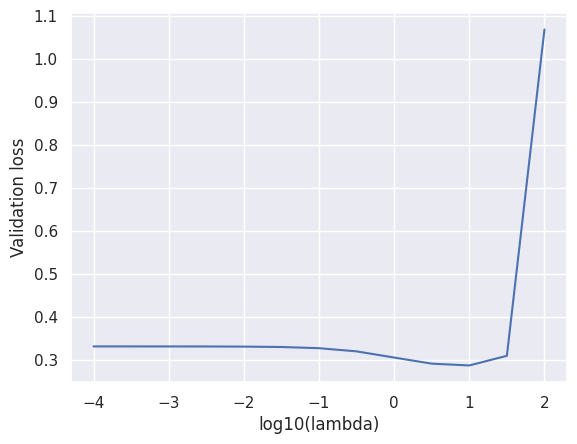

In [39]:
lambdas = 10 ** np.arange(-4, 4, step = 0.5)
val_nll = np.zeros_like(lambdas)

for i,lamb in enumerate(lambdas): # try different settings of lambda
    beta,_ = fit_logistic_reg( X_train_1, y_bin_train, l2_lambda = lamb, learning_rate = 0.01, iterations = 100 )
    pred_val = torch.sigmoid(X_val_1 @ beta) # make predictions on the validation set
    val_nll[i] = - torch.mean( y_bin_val * torch.log(pred_val) + (1.-y_bin_val) * torch.log(1.-pred_val) ).item() # item() gets the scalar value

plt.plot(np.log10(lambdas), val_nll)
plt.xlabel("log10(lambda)")
plt.ylabel("Validation loss")

Note that the optimization diverges for large values of lambda, we'll ignore this for now.

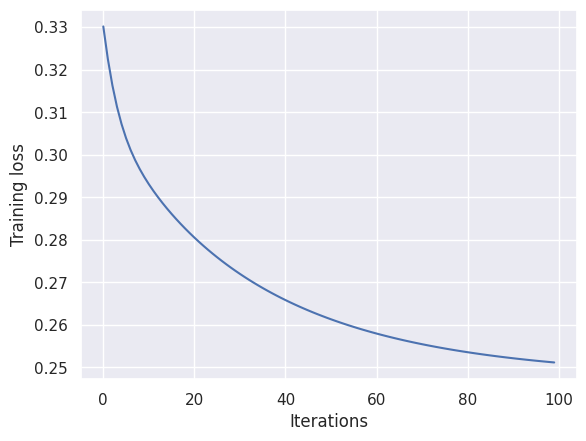

In [40]:
optimal_lamb = lambdas[np.nanargmin(val_nll)]
beta_logr,losses = fit_logistic_reg(X_train_1,
                                    y_bin_train,
                                    l2_lambda = optimal_lamb)
_ = plt.plot(losses)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Training loss")

Finally let's assess performance on the test data using a [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

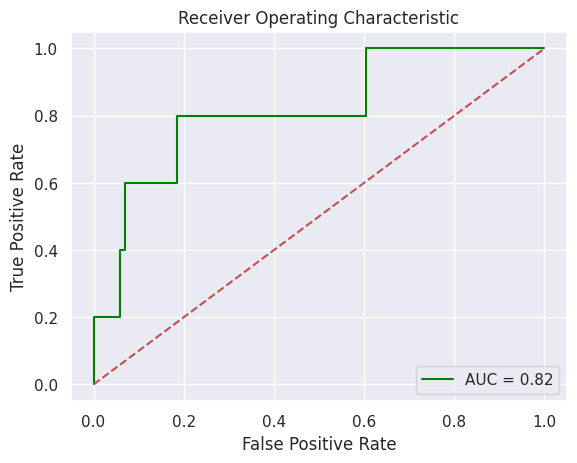

In [41]:
import sklearn.metrics as metrics
val_pred = torch.sigmoid(X_test_1 @ beta_logr)
fpr, tpr, _ = metrics.roc_curve(y_bin_test.cpu().numpy(), val_pred.cpu().numpy())
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr,color="green", label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random prediction gives an AUC of 0.5, so this is considerably better than that but still not great! This is a difficult prediction task!

## Neural networks

We'll use a Python class to hold the multiple parameters (weight matrices and intercepts) that make up the neural network. This also lets us conviently encapsulate associated functions to calculate the loss and gradient and to perform GD.

**You'll implement backprop again following a recipe as above for logistic regression. [4 points]**

I strongly recommend drawing out the computation graph for one layer and working out the math by hand before you start trying to code this!

Note that variables called e.g. `dloss_dA` refers to $\frac{\partial L}{\partial A}$ and should have the same shape as `A`.

In [ ]:
class DNN:

    def __init__(self, dims, device, requires_grad = False):
        """Initialize Dense Neural Network

        Parameters
        ----------
        dims : array-like
            Array specifying number of neurons in (i.e. dimension of) each layer.
            dims[0] is the input dimension, last element dims[-1] is the output dimension. The
            number of hidden layers is len(dims)-1.
        device
            The torch device to use.
        requires_grad : bool
            Set to true to check calculations against pytorch's own autograd
            (or to False to save
        """
        
        self.weights = {}
        self.intercepts = {}
        self.num_hidden_layers = len(dims) - 2 # dims[0] = input dim,
        self.dloss_dweights = {}
        self.dloss_dintercept = {}
        for layer_idx in range(len(dims)-1):
            self.weights[layer_idx] = torch.randn(dims[layer_idx:layer_idx+2],
                                                  device=device) * np.sqrt(2. / dims[layer_idx])  # He initialization
            if requires_grad:
                self.weights[layer_idx].requires_grad = True
            self.intercepts[layer_idx] = torch.zeros(dims[layer_idx+1],
                                                     device=device,
                                                     requires_grad = requires_grad)

    def loss_and_gradient(self, X, y, obs_weights, backprop = True):
        hidden = {} # dictionary to store activations/outputs of each layer. hidden[i] = output of layer i
        hidden[-1] = X # use hidden[-1] to denote the model input X
        # forward
        for layer_idx in range(self.num_hidden_layers + 1):
            g = hidden[layer_idx - 1] @ self.weights[layer_idx] + self.intercepts[layer_idx]
            hidden[layer_idx] = torch.relu(g) if (layer_idx < self.num_hidden_layers) else g # don't run ReLU on output layer
        output = hidden[self.num_hidden_layers] # output of final layer is the DNN output
        err = y - output
        loss = .5 * torch.sum(obs_weights * err * err) / obs_weights.sum()

        # backpropagation
        if backprop:
            
            dloss_dhidden = {}
            dloss_dhidden[self.num_hidden_layers] = - obs_weights * err / obs_weights.sum() #calculates the gradient of the loss with respect to the output (final layer's activations). It uses the error between the predicted output and the actual target (i.e., err = y - output) and scales it by the observation weights.
            # remember hidden[self.num_hidden_layers] is the model output
            # starting from the last hidden layer, moving towards the input layer.
            for layer_idx in range(self.num_hidden_layers, -1, -1): # iterate backwards through each layer
                if layer_idx < self.num_hidden_layers:
                    #. The derivative of ReLU is 1 for positive values and 0 for negative values. 
                    dloss_dg = torch.where(hidden[layer_idx] > 0, 1, 0) * dloss_dhidden[layer_idx]
                    # TODO TODO: when will the grad of relu be 0 or 1 as function of hidden[layer_idx]?
                else:
                    dloss_dg = dloss_dhidden[layer_idx] # for the output layer g == output
                assert(dloss_dg.shape == hidden[layer_idx].shape)
                
                #gradients of the loss concerning the weights and biases for the current layer.
                self.dloss_dweights[layer_idx] = torch.mm(hidden[layer_idx - 1].transpose(0, 1), dloss_dg) # multivariate chain rule
                assert(self.dloss_dweights[layer_idx].shape == self.weights[layer_idx].shape)

                self.dloss_dintercept[layer_idx] = torch.sum(dloss_dg, axis=0) # could do this with chain rule, but there's a more efficient way
                assert(self.dloss_dintercept[layer_idx].shape == self.intercepts[layer_idx].shape)
                #computes the gradient of the loss concerning the activations of the previous layer, which will be used in the next iteration of the loop. It essentially propagates the gradient backward through the network.
                dloss_dhidden[layer_idx - 1] = torch.mm(dloss_dg, self.weights[layer_idx].transpose(0, 1)) # chain rule and recurse back to next layer. input of this layer is the output of the previous layer
                assert(dloss_dhidden[layer_idx - 1].shape == hidden[layer_idx - 1].shape)

        return(loss,output) # g is the final network output

    def grad_step(self, X, y, obs_weights, learning_rate = 0.001):
        loss,_ = self.loss_and_gradient(X, y, obs_weights)
        for layer_idx in range(self.num_hidden_layers + 1):
            self.weights[layer_idx] -= learning_rate * self.dloss_dweights[layer_idx]
            self.intercepts[layer_idx] -= learning_rate * self.dloss_dintercept[layer_idx]
        return(loss)

    def cache_parameters(self):
        self.cached_weights = { k:v.detach().clone() for k,v in self.weights.items() }
        self.cached_intercepts = { k:v.detach().clone() for k,v in self.intercepts.items() }

    def recover_cache(self):
        self.weights = self.cached_weights
        self.intercepts = self.cached_intercepts

    def gradient_descent(self, X, y, obs_weights, X_val, y_val, obs_weights_val, iterations = 100, learning_rate = 0.001):
        losses = []
        val_losses = []
        patience = 10 # for early stopping
        patience_counter = patience
        best_val_loss = np.inf
        for it in range(iterations):
            loss = self.grad_step(X, y, obs_weights, learning_rate = learning_rate)
            losses.append(loss.item())
            val_loss,_ = self.loss_and_gradient(X_val, y_val, obs_weights_val, backprop = False)
            val_losses.append(val_loss.item())
            if val_loss < best_val_loss:
                self.cache_parameters()
                best_val_loss = val_loss
                patience_counter = patience
            else:
                patience_counter -= 1
                if patience_counter <= 0:
                    print("Early stopping at iteration %i" % it)
                    self.recover_cache() # recover the best model so far
                    break
        return(losses,val_losses)

In [43]:
dnn = DNN([X.shape[1], 16, 1], device = device, requires_grad=True)
loss,_ = dnn.loss_and_gradient(X_train, y_train[:,None], torch.ones_like(y_train[:,None]))
loss.backward()
assert( ( dnn.dloss_dweights[0] - dnn.weights[0].grad ).abs().mean().item() < 1e-8 )

Text(0, 0.5, 'MSE Loss')

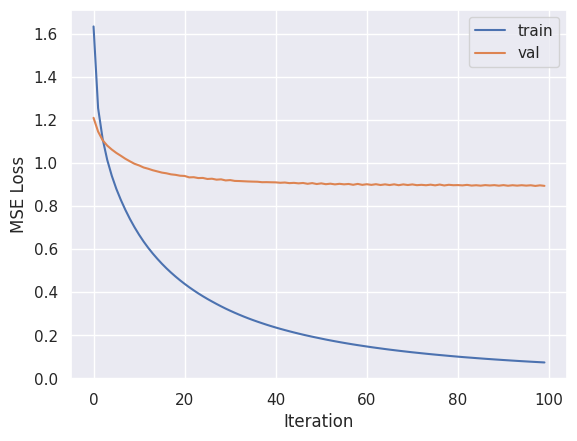

In [44]:
dnn = DNN([X.shape[1], 16, 1], device = device, requires_grad=False)
losses,val_losses = dnn.gradient_descent(X_train,
                                         y_train[:,None],
                                         torch.ones_like(y_train[:,None]),
                                         X_val,
                                         y_val[:,None],
                                         torch.ones_like(y_val[:,None]))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

First NN!

A common strategy in DL is [early stopping](https://en.wikipedia.org/wiki/Early_stopping) where we stop (S)GD when the performance on the validation data stops improving. This is an implicit form of regularization in contrast with the explicit L1 and L2 regularization terms we used for linear/logistic regression.

Early stopping is a regularization technique to prevent overfitting in training deep learning models. When we train a model, its performance improves with each iterations on the training data, but after a certain point, its performance on validation or test data may start to degrade, indicating overfitting. Early stopping intervenes by stopping the training process once the model's performance on the validation set ceases to improve.


Let's check predictive performance on the test set.

Test loss: 0.879325


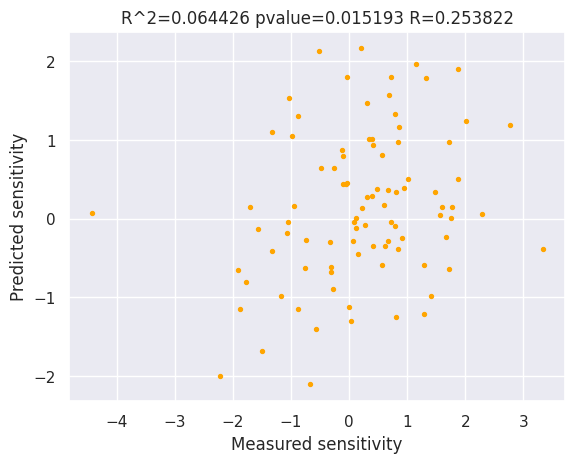

In [45]:
test_loss,pred_test = dnn.loss_and_gradient(X_test, y_test[:,None], torch.ones_like(y_test[:,None]))
print("Test loss: %f" % test_loss.item())
pred_test = pred_test.flatten() # remove spurious extra dimension
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu(),color="orange",s=8)
plt.title("R^2=%f pvalue=%f R=%f" % (R**2, p, R))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

Here the DNN predicts better than random ( 𝑝<0.05 ) on the test set, but worse than ridge or lasso regression. Why might that be (in general or for this application in particular)? (Give two reasons) [2 points]

1. DNNs are good at finding complex patterns. But, if our data mainly shows a straight-line type of relationship between gene expression and drug sensitivity, then simpler methods like ridge and lasso regression might work better. These simpler methods are made to find and understand straight-line patterns. In trying to find complex patterns, a DNN might introduce complexity, trying to find relationships or patterns that aren't necessarily present or significant.

2. Overfitting: DNNs have lots of parts that adjust to data. So, they can sometimes work too well on the data they're trained on but not do well on new data. This is because they might learn every tiny detail, including noise or mistakes in the training data. 

What could you try to improve the DNN's performance? (Give two suggestions) [2 points]

1. Adjust the Learning Rate: The learning rate controls how much we adjust our model in response to the estimated error each time the model weights are updated. The chosen value of 0.001 might not be the best for our dataset. By experimenting with higher or lower values, we can potentially achieve a faster convergence or a more accurate model.


2. Integrate more data:  With more data, the DNN can potentially generalize better and become more robust. If our current dataset primarily exhibits a linear relationship and is limited in size, then expanding it might allow the DNN to capture more complex and subtle patterns, improving its performance.

In [46]:
class StepDecay:
    def __init__(self, initial_lr, drop_factor, iterat_drop):
        self.initial_lr = initial_lr
        self.drop_factor = drop_factor
        self.iterat_drop = iterat_drop

    def get_lr(self, current_iterat):
        return self.initial_lr * (self.drop_factor ** (current_iterat // self.iterat_drop))


In [47]:
class DNN_2:

    def __init__(self, dims, device, requires_grad = False):
        """Initialize Dense Neural Network

        Parameters
        ----------
        dims : array-like
            Array specifying number of neurons in (i.e. dimension of) each layer.
            dims[0] is the input dimension, last element dims[-1] is the output dimension. The
            number of hidden layers is len(dims)-1.
        device
            The torch device to use.
        requires_grad : bool
            Set to true to check calculations against pytorch's own autograd
            (or to False to save
        """
        
        self.weights = {}
        self.intercepts = {}
        self.num_hidden_layers = len(dims) - 2 # dims[0] = input dim,
        self.dloss_dweights = {}
        self.dloss_dintercept = {}
        for layer_idx in range(len(dims)-1):
            self.weights[layer_idx] = torch.randn(dims[layer_idx:layer_idx+2],
                                                  device=device) * np.sqrt(2. / dims[layer_idx])  # He initialization
            if requires_grad:
                self.weights[layer_idx].requires_grad = True
            self.intercepts[layer_idx] = torch.zeros(dims[layer_idx+1],
                                                     device=device,
                                                     requires_grad = requires_grad)

    def loss_and_gradient(self, X, y, obs_weights, backprop = True):
        hidden = {} # dictionary to store activations/outputs of each layer. hidden[i] = output of layer i
        hidden[-1] = X # use hidden[-1] to denote the model input X
        # forward
        for layer_idx in range(self.num_hidden_layers + 1):
            g = hidden[layer_idx - 1] @ self.weights[layer_idx] + self.intercepts[layer_idx]
            hidden[layer_idx] = torch.relu(g) if (layer_idx < self.num_hidden_layers) else g # don't run ReLU on output layer
        output = hidden[self.num_hidden_layers] # output of final layer is the DNN output
        err = y - output
        loss = .5 * torch.sum(obs_weights * err * err) / obs_weights.sum()

        # backpropagation
        if backprop:
            dloss_dhidden = {}
            dloss_dhidden[self.num_hidden_layers] = - obs_weights * err / obs_weights.sum() # remember hidden[self.num_hidden_layers] is the model output
            for layer_idx in range(self.num_hidden_layers, -1, -1): # iterate backwards through each layer
                if layer_idx < self.num_hidden_layers:
                    dloss_dg = torch.where(hidden[layer_idx] > 0, 1, 0) * dloss_dhidden[layer_idx]
                    # TODO TODO: when will the grad of relu be 0 or 1 as function of hidden[layer_idx]?
                else:
                    dloss_dg = dloss_dhidden[layer_idx] # for the output layer g == output
                assert(dloss_dg.shape == hidden[layer_idx].shape)

                self.dloss_dweights[layer_idx] = torch.mm(hidden[layer_idx - 1].transpose(0, 1), dloss_dg) # multivariate chain rule
                assert(self.dloss_dweights[layer_idx].shape == self.weights[layer_idx].shape)

                self.dloss_dintercept[layer_idx] = torch.sum(dloss_dg, axis=0) # could do this with chain rule, but there's a more efficient way
                assert(self.dloss_dintercept[layer_idx].shape == self.intercepts[layer_idx].shape)

                dloss_dhidden[layer_idx - 1] = torch.mm(dloss_dg, self.weights[layer_idx].transpose(0, 1)) # chain rule and recurse back to next layer. input of this layer is the output of the previous layer
                assert(dloss_dhidden[layer_idx - 1].shape == hidden[layer_idx - 1].shape)

        return(loss,output) # g is the final network output

    def grad_step(self, X, y, obs_weights, learning_rate = 0.001):
        loss,_ = self.loss_and_gradient(X, y, obs_weights)
        for layer_idx in range(self.num_hidden_layers + 1):
            self.weights[layer_idx] -= learning_rate * self.dloss_dweights[layer_idx]
            self.intercepts[layer_idx] -= learning_rate * self.dloss_dintercept[layer_idx]
        return(loss)

    def cache_parameters(self):
        self.cached_weights = { k:v.detach().clone() for k,v in self.weights.items() }
        self.cached_intercepts = { k:v.detach().clone() for k,v in self.intercepts.items() }

    def recover_cache(self):
        self.weights = self.cached_weights
        self.intercepts = self.cached_intercepts

    def gradient_descent(self, X, y, obs_weights, X_val, y_val, obs_weights_val, iterations = 100, learning_rate = 0.001):
        losses = []
        val_losses = []
        patience = 10 # for early stopping
        patience_counter = patience
        best_val_loss = np.inf
        scheduler = StepDecay(initial_lr=learning_rate, drop_factor=0.5, iterat_drop=10) #we implemented this in order to have a learning rate that decreases over time

        for it in range(iterations):
            lr = scheduler.get_lr(it)
            print("Iteration %i, learning rate %f" % (it, lr))
            loss = self.grad_step(X, y, obs_weights, learning_rate=lr)
            losses.append(loss.item())
            val_loss,_ = self.loss_and_gradient(X_val, y_val, obs_weights_val, backprop = False)
            val_losses.append(val_loss.item())
            if val_loss < best_val_loss:
                self.cache_parameters()
                best_val_loss = val_loss
                patience_counter = patience
            else:
                patience_counter -= 1
                if patience_counter <= 0:
                    print("Early stopping at iteration %i" % it)
                    self.recover_cache() # recover the best model so far
                    break
        return(losses,val_losses)

Iteration 0, learning rate 0.001000
Iteration 1, learning rate 0.001000
Iteration 2, learning rate 0.001000
Iteration 3, learning rate 0.001000
Iteration 4, learning rate 0.001000
Iteration 5, learning rate 0.001000
Iteration 6, learning rate 0.001000
Iteration 7, learning rate 0.001000
Iteration 8, learning rate 0.001000
Iteration 9, learning rate 0.001000
Iteration 10, learning rate 0.000500
Iteration 11, learning rate 0.000500
Iteration 12, learning rate 0.000500
Iteration 13, learning rate 0.000500
Iteration 14, learning rate 0.000500
Iteration 15, learning rate 0.000500
Iteration 16, learning rate 0.000500
Iteration 17, learning rate 0.000500
Iteration 18, learning rate 0.000500
Iteration 19, learning rate 0.000500
Iteration 20, learning rate 0.000250
Iteration 21, learning rate 0.000250
Iteration 22, learning rate 0.000250
Iteration 23, learning rate 0.000250
Iteration 24, learning rate 0.000250
Iteration 25, learning rate 0.000250
Iteration 26, learning rate 0.000250
Iteration 2

Text(0, 0.5, 'MSE Loss')

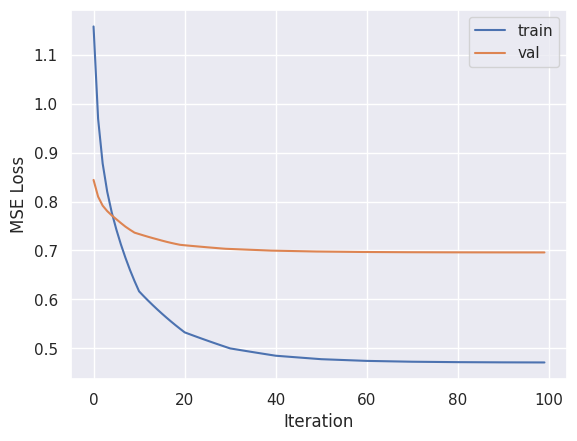

In [48]:
dnn = DNN_2([X.shape[1], 16, 1], device = device, requires_grad=False)
losses,val_losses = dnn.gradient_descent(X_train,
                                         y_train[:,None],
                                         torch.ones_like(y_train[:,None]),
                                         X_val,
                                         y_val[:,None],
                                         torch.ones_like(y_val[:,None]))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

0.6560601592063904


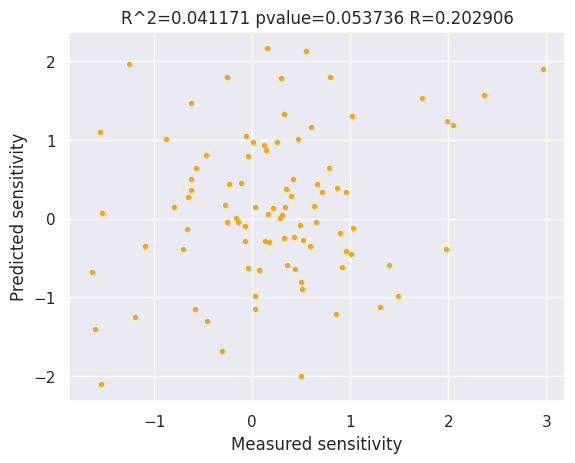

In [49]:
test_loss,pred_test = dnn.loss_and_gradient(X_test, y_test[:,None], torch.ones_like(y_test[:,None]))
print(test_loss.item())
pred_test = pred_test.flatten() # remove spurious extra dimension
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu(),color="orange",s=8)
plt.title("R^2=%f pvalue=%f R=%f" % (R**2, p, R))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

While we observed a decrease in the validation loss across different learning rates, several challenges can still influence the performance of our DNN. One significant challenge arises from the inherent randomness during network initialization and training. Every time the DNN is trained, it starts with different initial weights, and the optimization path it follows can vary, potentially leading to different final models even if the training data and architecture remain constant. Furthermore, if our dataset is not sufficiently large or diverse, the DNN might struggle to generalize. Instead of identifying true underlying patterns, it might overfit to the big differences and noise of the training data, essentially 'memorizing' the training set. This phenomenon can lead to excellent performance on the training data but poor generalization to unseen data, as the model has trained itself too closely to the training examples and not the broader problem domain.

## Multitask prediction

Neural networks naturally allow multitask prediction. We'll want to preprocess the data a little differentally for this, including cell lines where <50% of the IC50 values are missing and drugs where <40% is missing.

First let's select the cell lines to keep:

905

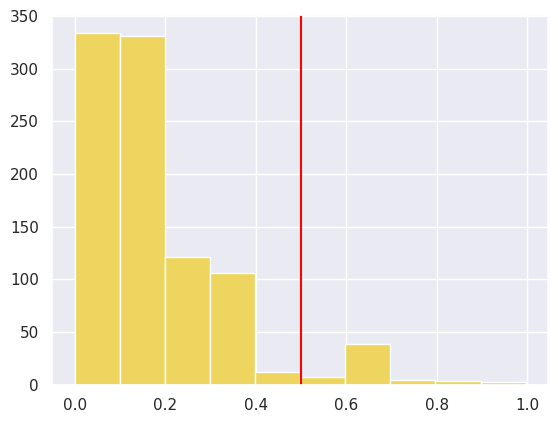

In [50]:
ic50_np = ic50.iloc[:,1:].to_numpy()
miss = np.isnan(ic50_np)
prop_miss_cell = miss.mean(1)
cell_to_keep = prop_miss_cell < 0.5
plt.hist(prop_miss_cell,color="#edd55f")
plt.axvline(0.5, color = "red")
cell_to_keep.sum()

905 cell lines are included. Now we'll select the drugs to keep:

217

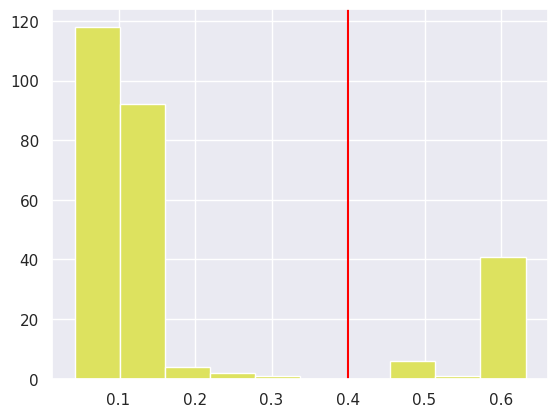

In [51]:
prop_miss_drug = miss.mean(0)
drug_to_keep = prop_miss_drug < 0.4
plt.hist(prop_miss_drug,color="#dde25f")
plt.axvline(0.4, color = "red")
drug_to_keep.sum()

217 drugs are included. We'll normalize the data as before, also keeping track of which elements of `y` are missing through `obs_weight` (1=not missing, 0=missing).

In [52]:
y_all = ic50_np[np.ix_(cell_to_keep, drug_to_keep)]
obs_weight = torch.tensor(~np.isnan(y_all), device = device, dtype = torch.float) # nan values = missing
y_all[np.isnan(y_all)]=0. # set to 0 since these points will be ignored anyway by the masking
y_unnorm = torch.tensor(y_all, device = device, dtype = torch.float)
y_mt = (y_unnorm - y_unnorm.mean(0, keepdims=True)) / y_unnorm.std(0, keepdims=True) # normalize

X_unnorm = torch.tensor(X_all[cell_to_keep,:], device = device, dtype = torch.float)
X_mt = (X_unnorm - X_unnorm.mean(0, keepdims=True)) / X_unnorm.std(0, keepdims=True)

In [53]:
N = y_mt.shape[0]

np.random.seed(1) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]

X_mt_train = X_mt[train_idx,:]
X_mt_val = X_mt[val_idx,:]
X_mt_test = X_mt[test_idx,:]

y_mt_train = y_mt[train_idx,:]
y_mt_val = y_mt[val_idx,:]
y_mt_test = y_mt[test_idx,:]

obs_weight_train = obs_weight[train_idx,:]
obs_weight_val = obs_weight[val_idx,:]
obs_weight_test = obs_weight[test_idx,:]

Let's try training with 64 hidden units. Here we're training one model that outputs predictions for every drug, so we want y_mt.shape[1]==217 output dimensions.

Early stopping at iteration 767


1.0843315124511719

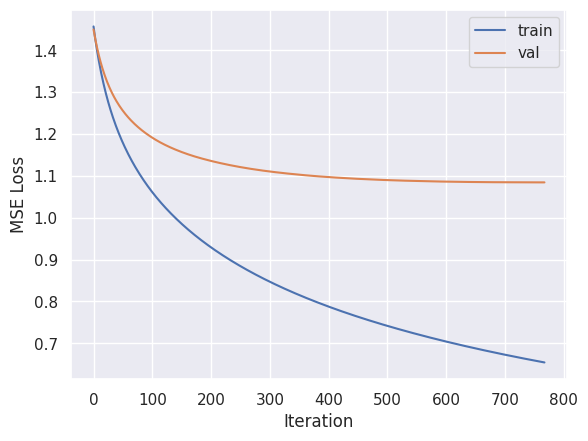

In [54]:
dnn_mt = DNN([X_mt.shape[1], 64, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = dnn_mt.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
min(val_losses)

In [55]:
test_loss,_ = dnn_mt.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
test_loss.item()

1.0566151142120361

How does it compare with 32 units each?


0.8132028579711914

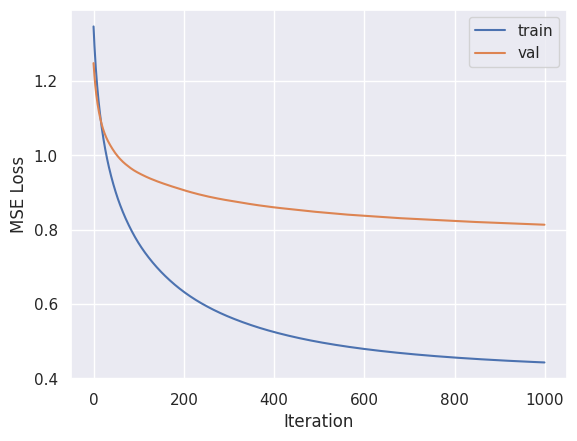

In [56]:
dnn_mt_2 = DNN([X_mt.shape[1], 32, 32, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = dnn_mt_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
min(val_losses)

In [57]:
test_loss,_ = dnn_mt_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
test_loss.item()

0.8122750520706177

The two layer model tends to do better than the wider one layer model (just slightly)

*Try playing with the depth and width of the network to get the best performance you can. Write up your findings including plotting performance vs depth or performance vs width* [4 points].

DEPTH: number of layers  WIDTH: neurons in each layer


In [60]:
#dims : array-like
#          Array specifying number of neurons in (i.e. dimension of) each layer.
#          dims[0] is the input dimension, last element dims[-1] is the output dimension. The
#          number of hidden layers is len(dims)-1.

results = {}
depths= [1, 2, 3, 4]
widths= [16, 32, 64]
#First we will calculate the gradient descent with different combinations of layers and nodes
for depth in depths:
    for width in widths:
        print("Depth: %i, Width: %i" % (depth, width))
        dims = [X_mt.shape[1]] + [width] * depth + [y_mt.shape[1]] # creating combinations of layers and nodes
        dnn_mt = DNN(dims, device=device, requires_grad=False)
        _, val_losses = dnn_mt.gradient_descent( X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)
        
        results[(depth, width)] = min(val_losses)
        print("Validation loss: %f" % results[(depth, width)])


Depth: 1, Width: 16
Early stopping at iteration 164
Validation loss: 1.113446
Depth: 1, Width: 32
Early stopping at iteration 294
Validation loss: 1.052296
Depth: 1, Width: 64
Early stopping at iteration 708
Validation loss: 1.144005
Depth: 2, Width: 16
Early stopping at iteration 120
Validation loss: 1.428845
Depth: 2, Width: 32
Validation loss: 1.053807
Depth: 2, Width: 64
Validation loss: 0.816390
Depth: 3, Width: 16
Validation loss: 0.994616
Depth: 3, Width: 32
Validation loss: 0.931498
Depth: 3, Width: 64
Validation loss: 0.710466
Depth: 4, Width: 16
Validation loss: 0.594410
Depth: 4, Width: 32
Validation loss: 0.651040
Depth: 4, Width: 64
Validation loss: 0.638141


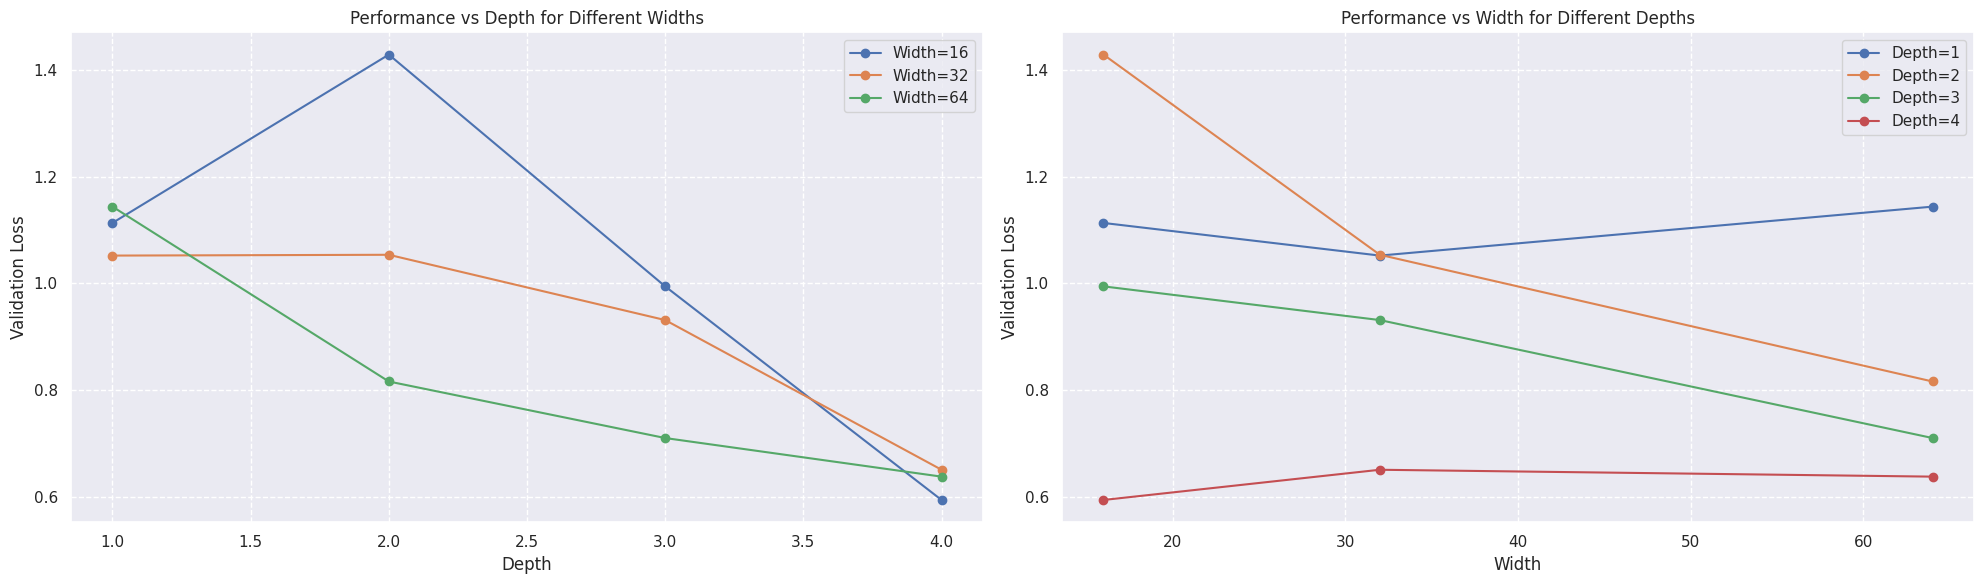

In [ ]:
plt.figure(figsize=(20, 6))

# First plot: Performance vs Depth for Different Widths
plt.subplot(1, 2, 1)

unique_widths = set([width for depth, width in results.keys()])
for width in unique_widths:
    depths_to_plot = [depth for depth, w in results.keys() if w == width]
    losses_to_plot = [results[(depth, width)] for depth in depths_to_plot]
    
    sorted_indices = np.argsort(depths_to_plot)  # Ensure depths are in increasing order
    depths_to_plot = np.array(depths_to_plot)[sorted_indices]
    losses_to_plot = np.array(losses_to_plot)[sorted_indices]
    
    plt.plot(depths_to_plot, losses_to_plot, marker='o', label=f"Width={width}")

plt.xlabel('Depth')
plt.ylabel('Validation Loss')
plt.title('Performance vs Depth for different widths')
plt.legend()
plt.grid(True, which="both", ls="--")

# Second plot: Performance vs Width for Different Depths
plt.subplot(1, 2, 2)

unique_depths = set([depth for depth, width in results.keys()])
for depth in unique_depths:
    widths_to_plot = [width for d, width in results.keys() if d == depth]
    losses_to_plot = [results[(depth, width)] for width in widths_to_plot]
    
    sorted_indices = np.argsort(widths_to_plot)
    widths_to_plot = np.array(widths_to_plot)[sorted_indices]
    losses_to_plot = np.array(losses_to_plot)[sorted_indices]
    
    plt.plot(widths_to_plot, losses_to_plot, marker='o', label=f"Depth={depth}")

plt.xlabel('Width')
plt.ylabel('Validation Loss')
plt.title('Performance vs Width for different depths')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


- DEPTH: number of layers  
- WIDTH: neurons in each layer

The loss provides a measure of how well the model's predictions match the true labels in the data. The loss quantifies the error or discrepancy between the actual and predicted values. 
- A lower loss typically indicates that your model's predictions are closer to the true labels, suggesting better model performance.
- Conversely, a higher loss suggests that there's a greater discrepancy between the predictions and the true labels, indicating poorer model performance.

In the plot contrasting depth against performance, we observe a distinct trend: increasing the number of layers consistently enhances the model's efficacy, as reflected by improved loss values. Initially, when we experimented with varying neuron counts per layer, the network with the highest neuron density demonstrated superior performance. However, as we incorporated four layers across all configurations, the performance disparities between different neuron counts diminished. This suggests that while neuron density in layers has its role, the depth of the network emerges as a more pivotal factor in determining model efficiency (which is also observed in the right plot, red line). 

## Extra

In [73]:
from sklearn.model_selection import KFold
import math

"""Performs nfold cross-validation for LASSO regression"""

def cross_val_lasso(X, y, lamb, learning_rate=0.001, iterations=1000, nfold=10):

    kf = KFold(n_splits=nfold, shuffle=True, random_state=1234)

    fold_losses = []

    for train_indices, val_indices in kf.split(X):

        # Splitting the data into training and validation sets
        X_train_fold, X_val_fold = X[train_indices], X[val_indices]
        y_train_fold, y_val_fold = y[train_indices], y[val_indices]

        beta, losses = fit_lasso(X_train_fold, y_train_fold, lamb, learning_rate, iterations)
        
        #MSE loss
        val_loss = .5 * torch.pow(y_val_fold - X_val_fold @ beta, 2).mean()
        
        fold_losses.append(val_loss.item())

    # Average validation loss across folds
    avg_val_loss = np.mean(fold_losses)

    return avg_val_loss




In [72]:
lamb_value = 0.01
avg_loss = cross_val_lasso(X, y, lamb=lamb_value)
print(f"Average validation loss across 10-fold cross-validation for log10 lambda={math.log10(lamb_value)}:", avg_loss)


Average validation loss across 10-fold cross-validation for lambda=-2.0: 0.45390031337738035


When we initially trained our Lasso model with a lambda value of 0.01, using a singular train-test split, we observed a loss value of 0.88. This performance metric was dependent on that specific data split, potentially offering a skewed representation of the model's capability. However, by employing a 10-fold cross-validation approach with the same lambda value, we observe a more comprehensive evaluation, which yielded an improved performance metric of 0.453. This enhancement in performance underscores the importance of cross-validation: by averaging over multiple train-validation data splits, it offers a more robust and accurate measure of a model's performance, reducing biases that might emerge from any single data partition.